In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [13]:
df_train = pd.read_csv("food.csv")

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import os

# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
!pip install -q -U watermark

In [9]:
!pip install -qq transformers

In [11]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

numpy       : 1.24.3
pandas      : 1.5.3
torch       : 2.0.1+cu117
transformers: 4.31.0



In [12]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Exploration

In [14]:
df_train.head(10)

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,very good
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,bad
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,very good
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,very good
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,very good
5,শহরের সেরা বাফেটের সেরা অফার.মিস করলেই হবে লস্...,very good
6,যারা Kabab lovers আছে তাদের জন্য Unlimited Kab...,very good
7,বিদেশী অক্টোপাস ৩০০ ফিট ১০০০/৯০০০৳ হাজার টাকার...,good
8,ধানমন্ডির মধ্যে সেরা এক নাম্বার বাজে বুফে the ...,bad
9,মিড রেঞ্জের মধ্যে পয়সাউসুল প্রিমিয়াম একটি ব্যু...,very good


# Label 0, 1 or 2 . '0' for neutral, '1' for positive and '2' for negative

In [15]:
mapping = {'bad': 0, 'good': 1, 'very good': 2}

In [16]:
mapping = {'bad': 0, 'good': 1, 'very good': 2}
df_train['Type'] = df_train['Type'].map(mapping)
df_train

In [18]:
df_train

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,2
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,0
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,2
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,2
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,2
...,...,...
109,"মেইন কোর্সে ছিলো খিচুড়ি, খাসির বিরিয়ানি, বীফ র...",1
110,বেশ অনেকদিন থেকেই যাওয়ার ইচ্ছা ছিলো। এট লাস্ট ...,1
111,রিফিলের অবস্থা খুবই বাজে।ব্যুফের সময় ১:০০ টা ব...,0
112,The Pan Pacific Lounge এ গতকাল একটি নেগেটিভ রি...,0


In [19]:
df_train.shape

(114, 2)

In [20]:
df_train[:]

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,2
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,0
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,2
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,2
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,2
...,...,...
109,"মেইন কোর্সে ছিলো খিচুড়ি, খাসির বিরিয়ানি, বীফ র...",1
110,বেশ অনেকদিন থেকেই যাওয়ার ইচ্ছা ছিলো। এট লাস্ট ...,1
111,রিফিলের অবস্থা খুবই বাজে।ব্যুফের সময় ১:০০ টা ব...,0
112,The Pan Pacific Lounge এ গতকাল একটি নেগেটিভ রি...,0


In [22]:
df_train['Type'].value_counts()

2    59
1    39
0    16
Name: Type, dtype: int64

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  114 non-null    object
 1   Type    114 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


In [24]:
class_names = ['bad', 'good','very good']

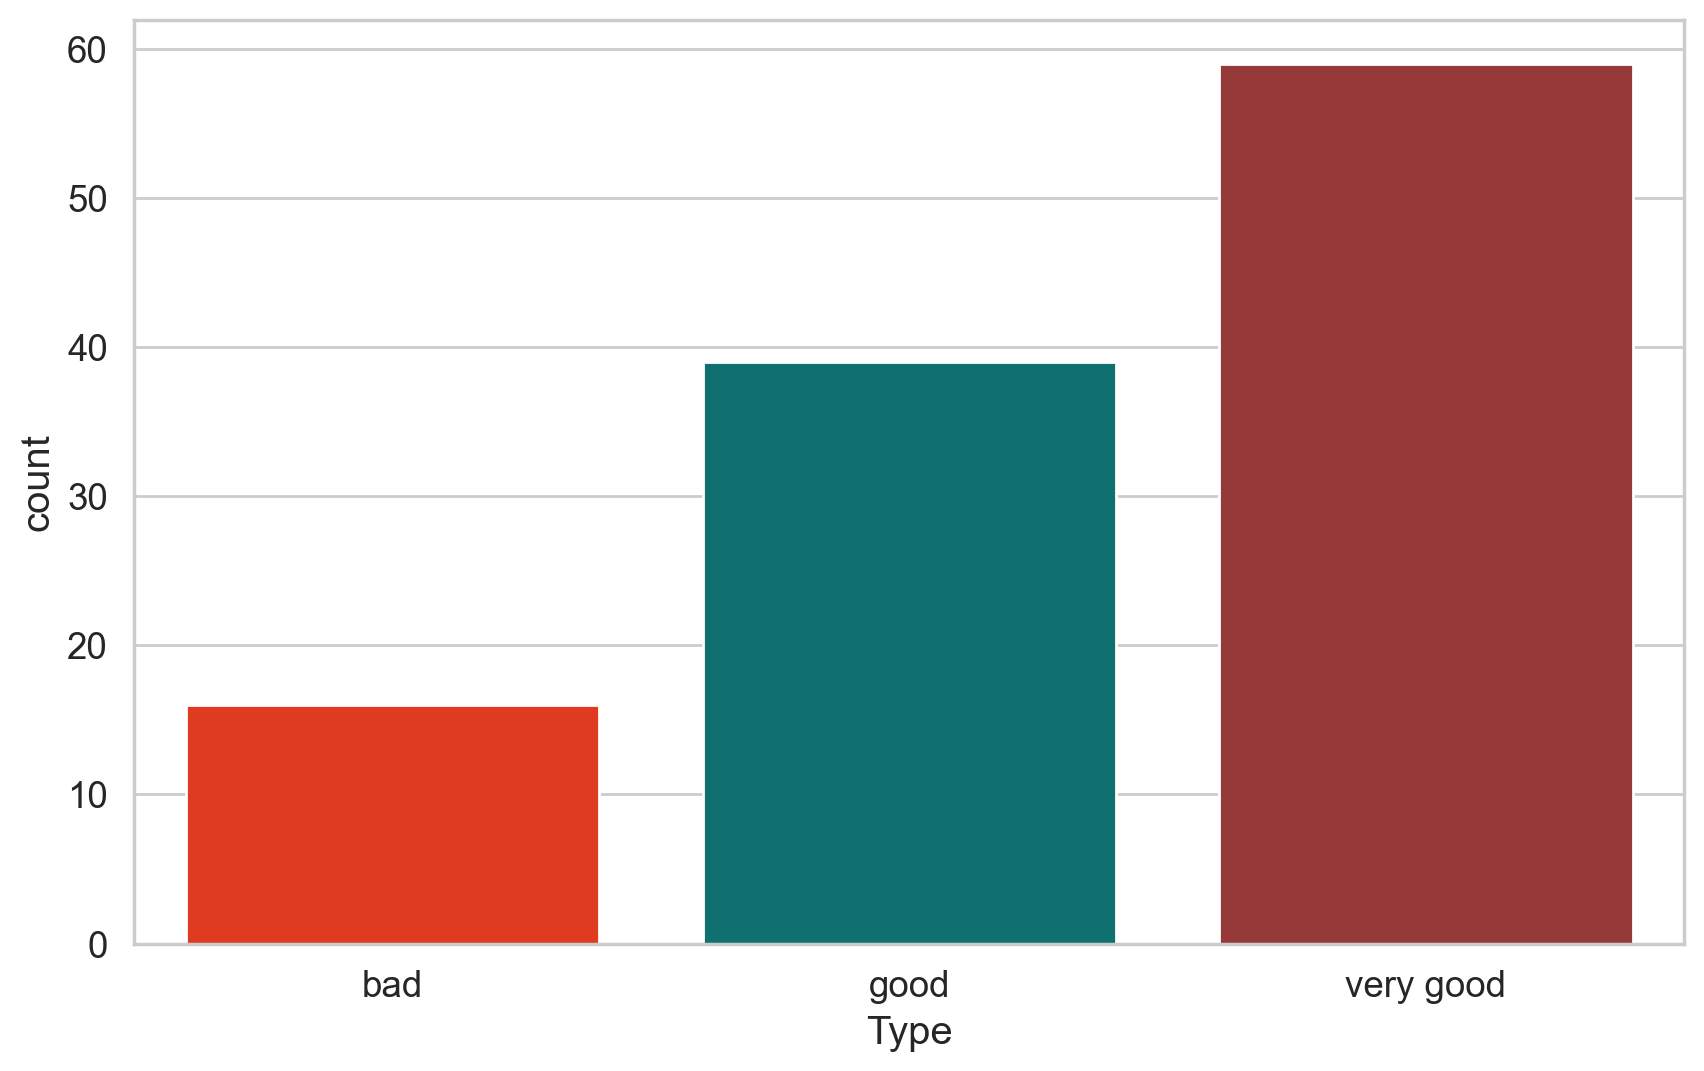

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

Toxic_count = df_train['Type'].value_counts()
#sns.countplot(x='Score', data=df, order=Toxic_count.index)
#sns.countplot(x='Score', data=df, order=Toxic_count.index, color='blue')
sns.countplot(x='Type', data=df_train, palette=['#FF2400', 'teal','#A52A2A','Seagreen'])
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()

In [26]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [27]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert'

In [28]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

In [29]:
pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to c:\users\pirat\appdata\local\temp\pip-req-build-r2rt8kcq
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/185.0 kB ? eta -:--:--
     ------                                  30.7/185.0 kB 1.3 MB/s eta 0:00:01
     ------------                          61.4/185.0 kB 656.4 kB/s eta 0:00:01
     ---------------------                112.6/185.0 kB 930.9 kB/s eta 0:00:01
     -----------------------------------    174.1/185.0 kB 1.1 MB/s eta 0:00:01
     -------------------------------------- 185.0/185.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/64.2 kB ? eta -:--:--
     --------------------------------

  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer 'C:\Users\pirat\AppData\Local\Temp\pip-req-build-r2rt8kcq'


In [30]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
import torch

In [31]:
sample_txt= "আমি কৃতজ্ঞ কারণ আপনি আমার জন্য অনেক কিছু করেছেন।"

In [32]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

# Choosing Sequence Length

In [34]:
token_lens = []

for txt in df_train.Review:
  txt = normalize(txt) # this normalization step is required before tokenizing the text
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


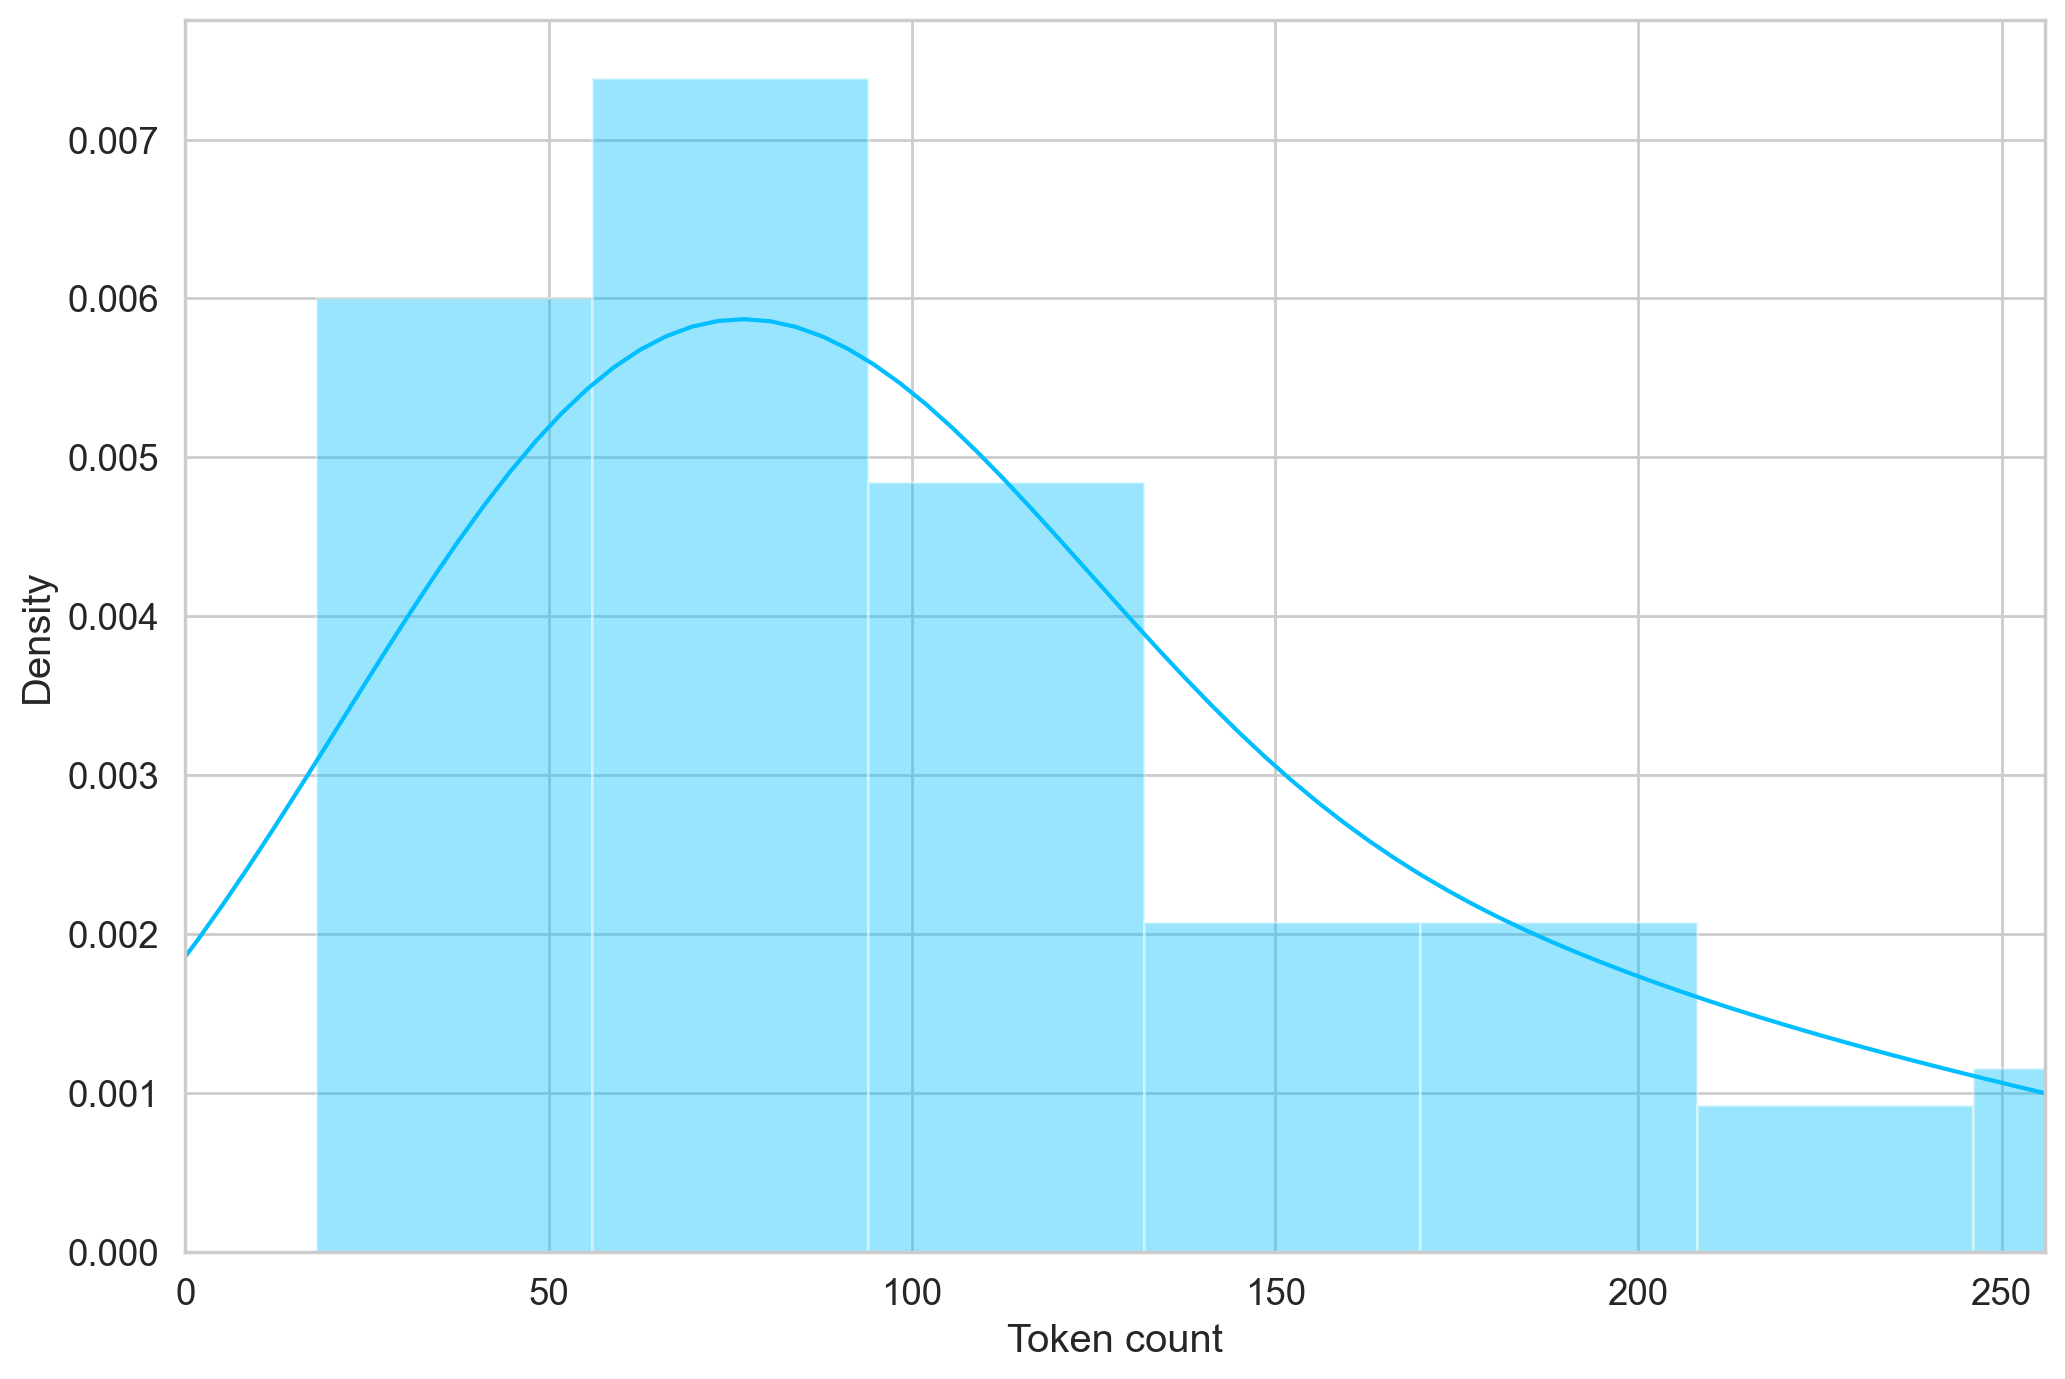

In [35]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [36]:
MAX_LEN = 256

In [43]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [44]:
df_train.shape

(114, 2)

In [49]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Review.to_numpy(),
    targets=df.Type.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [50]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'